In [6]:
import time

import numpy as np
from numpy.random import normal

In [57]:
x = normal(size=(5, 5*10**7))

In [59]:
%timeit np.save('test.npy', x)

14.8 s ± 236 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [55]:
y = normal(size=(5*10**7))

In [60]:
%timeit np.save('test1.npy', y)

3.01 s ± 31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


overhead ignorable. proceed saving each var in individual file

In [65]:
import time

t0 = time.time()
for i in range(15):
    x[i] = np.random.normal(size=5*10**7) # standard normal
    filename = f'train/x_{i:03}.npy'
    np.save(filename, x) # x_00.npy, x_01.npy, x_02.npy ...x_14.npy
print(f'elapsed: {time.time()-t0}')

In [7]:
t0 = time.time()
X = [None] * 15
for i in range(15):
    filename = f'train/x_{i:03}.npy'
    X[i] = np.load(filename)
print(f'elapsed: {time.time()-t0}')

elapsed: 42.64884924888611


In [9]:
f0 = None

f1 = None

def f2(X):
    "Compute y from x."
    return X[0]**2

def f3(X):
    return X[0] * X[1]

def f4(X):
    return X[0]**2 + X[1]**2 + 2*X[2]*X[3]

def f5(X):
    return X[0]**3*X[1]

def f6(X):
    return X[0]**2 * X[1]**2 + X[2] * X[3]

In [10]:
fs = [f0, f1, f2, f3, f4, f5, f6]

In [13]:
noise_1 = np.random.normal(size=X[0].shape)


# How to add noise?
Let 
$A = Var(Y)$
$B = Cov(Y, N)$
$C = Var(N)$.

Given $r$, We want to set $p$ (perturbation) such that Corr(Y+pN, Y) = r.

First, by definition,

$$r = \frac{\text{Corr}(Y+pN, Y)}{\sigma(Y+pN)\sigma(Y)}$$

So

$$r^2 = \frac{(\text{Corr}(Y+pN, Y))^2}{\text{Var}(Y+pN)\text{Var}(Y)}$$



By multilinearity of $\text{Corr}$, we have

$$\text{Corr}(Y+pN, Y) = A+pB$$

Also,
$$\text{Var}(Y+xN) = A+2pB+p^2C$$

So,

$$r = \frac{A+pB}{\sqrt{A}\sqrt{(A+2pB+p^2C)}}$$

I can use sympy to solve for $p$.

In [33]:
from sympy import *
from sympy.abc import *
from IPython.display import display

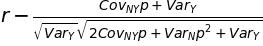

In [119]:

display(expr)

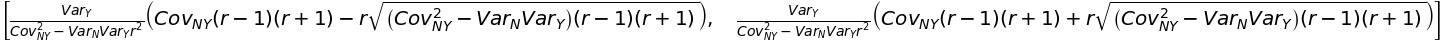

In [121]:
display(solve(expr, sympify('p')))
p_1, p_2 = solve(expr, sympify('p'))


In [124]:
Var_Y, Cov_NY, Var_N, r = sympify('Var_Y, Cov_NY, Var_N, r')
args = (Var_Y, Cov_NY, Var_N, r) # argument symbols
fun1, fun2 = lambdify(args, p_1), lambdify(args, p_2)

In [125]:
r_v = 0.2
argv = (np.var(Y), np.cov(Y, N)[0][1], np.var(N), r_v) # argument values

In [127]:
p_v = fun1(*argv), fun2(*argv)

In [128]:
np.corrcoef(x=Y, y=Y+p_v[1]*N)

array([[ 1.        ,  0.20004918],
       [ 0.20004918,  1.        ]])

In [3]:
Var_Y, Cov_NY, Var_N, r = sympify('Var_Y, Cov_NY, Var_N, r')
args = (Var_Y, Cov_NY, Var_N, r) # argument symbols

expr = sympify('''r - (Var_Y+p*Cov_NY)/( sqrt(Var_Y+2*p*Cov_NY + p*p*Var_N) * sqrt(Var_Y) )''')
p_solutions = solve(expr, sympify('p'))
fun_true = lambdify(args, p_solutions[1]) # second solution is true;
#Note: the other solutions works when Y_n = Y-pN

def add_noise(Y, N, r = 0.1):
    """
    Add N as linear noise to Y such that $\text{Corr}(Y, Y+pN) = r$
    Parameters:
        Y: data values
        N: noise values
        r: target correlation
    Returns: (Y_n, p)
        Y_n: noised Y: Y_n = Y+pN
        p  : coefficient needed
    """
    arg_values = (
        np.var(Y),
        np.cov(Y,N)[0][1],
        np.var(N),
        r)
    p = fun_true(*arg_values)
    return Y+p*N, p

<function numpy.<lambda>>

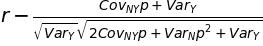

In [8]:
display(expr)

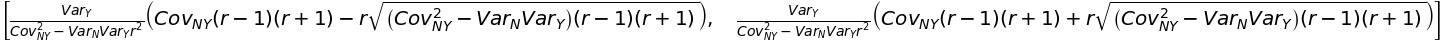

In [9]:
display(p_solutions)

In [142]:
# TEST
YN = np.random.multivariate_normal(np.array([0,0]), np.array(([1, 0],[0, 1])), size=10000)
Y = YN[:,0]
N = YN[:,1]
Y_N, p = add_noise(Y, N, r = 0.0001)
display(np.corrcoef(x=Y, y=Y_N))

array([[  1.00000000e+00,   1.00312979e-04],
       [  1.00312979e-04,   1.00000000e+00]])